In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint

In [2]:
stock1_ticker="BIOCON.NS"
stock2_ticker="PEL.NS"
stock1_data = yf.download(stock1_ticker, start='2022-02-01', end='2023-07-15')
stock2_data = yf.download(stock2_ticker, start='2022-02-01', end='2023-07-15')

stock1_close = stock1_data['Close']
stock2_close = stock2_data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
correlation = np.corrcoef(stock1_close, stock2_close)[0, 1]
correlation

0.9142405797792883

Text(0.5, 1.0, 'Closing Prices of Stock')

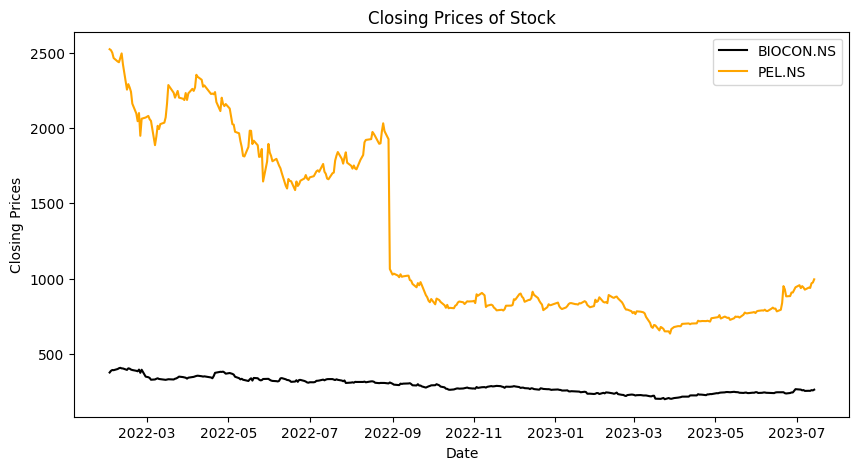

In [4]:
fig, ax=plt.subplots(figsize=(10,5))
ax.plot(stock1_close.index,stock1_close,label=stock1_ticker,color='black')
ax.plot(stock2_close.index,stock2_close,label=stock2_ticker,color='orange')
plt.xlabel('Date')
ax.legend()
plt.ylabel('Closing Prices')
plt.title('Closing Prices of Stock')

In [5]:
stock1_data['MA10']=stock1_close.rolling(10).mean()
stock1_data['MA50']=stock1_close.rolling(50).mean()
stock2_data['MA10']=stock2_close.rolling(10).mean()
stock2_data['MA50']=stock2_close.rolling(50).mean()

In [6]:
stock1_data.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-10  255.000000  256.350006  251.550003  254.699997  254.699997   
2023-07-11  256.000000  256.399994  252.550003  254.199997  254.199997   
2023-07-12  255.000000  262.350006  254.300003  259.149994  259.149994   
2023-07-13  260.399994  261.649994  256.000000  257.149994  257.149994   
2023-07-14  258.049988  263.399994  256.149994  262.200012  262.200012   

             Volume        MA10        MA50  
Date                                         
2023-07-10  3929446  254.459996  244.813000  
2023-07-11  2604446  255.884996  245.245999  
2023-07-12  4526585  257.434996  245.650999  
2023-07-13  2780982  258.784996  246.028999  
2023-07-14  2624910  258.454997  246.443000

In [7]:
stock2_data.tail()

Open         High         Low       Close   Adj Close  \
Date                                                                      
2023-07-10  930.000000   944.349976  918.349976  940.349976  940.349976   
2023-07-11  944.450012   948.900024  935.000000  937.950012  937.950012   
2023-07-12  940.000000   977.900024  936.049988  969.150024  969.150024   
2023-07-13  973.150024   999.849976  962.500000  973.799988  973.799988   
2023-07-14  980.000000  1004.000000  975.299988  995.299988  995.299988   

             Volume        MA10        MA50  
Date                                         
2023-07-10  1733801  929.265002  809.690995  
2023-07-11  1221022  934.665002  813.714995  
2023-07-12  3508314  940.810004  818.247996  
2023-07-13  4268724  947.420001  822.843995  
2023-07-14  3055144  952.720001  827.597996

In [19]:


def generate_signals(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    stock1_data['MA10']=stock1_close.rolling(10).mean()
    stock1_data['MA50']=stock1_close.rolling(50).mean()
    stock2_data['MA10']=stock2_close.rolling(10).mean()
    stock2_data['MA50']=stock2_close.rolling(50).mean()
    
    # Calculate the short-term and long-term SMAs for both assets
    signals['short_sma_asset1'] =stock1_data['MA10']
    signals['long_sma_asset1'] =stock1_data['MA50']
    
    signals['short_sma_asset2'] = stock2_data['MA10']
    signals['long_sma_asset2'] = stock2_data['MA50']
    # Generate signals based on SMA crossovers
    signals['signal'][short_window:] = np.where(
        signals['short_sma_asset1'][short_window:] > signals['long_sma_asset1'][short_window:], 1.0, 0.0
    )

    signals['signal'][short_window:] = np.where(
        signals['short_sma_asset2'][short_window:] > signals['long_sma_asset2'][short_window:], -1.0, signals['signal'][short_window:]
    )

    # Take the difference to get the final trading signals
    signals['positions'] = signals['signal'].diff()

    return signals



# Set the short and long SMA window periods
short_window = 10
long_window = 50

# Generate trading signals based on SMA crossovers
signals_stock1 = generate_signals(stock1_data, short_window, long_window)
signals_stock2 = generate_signals(stock2_data, short_window, long_window)


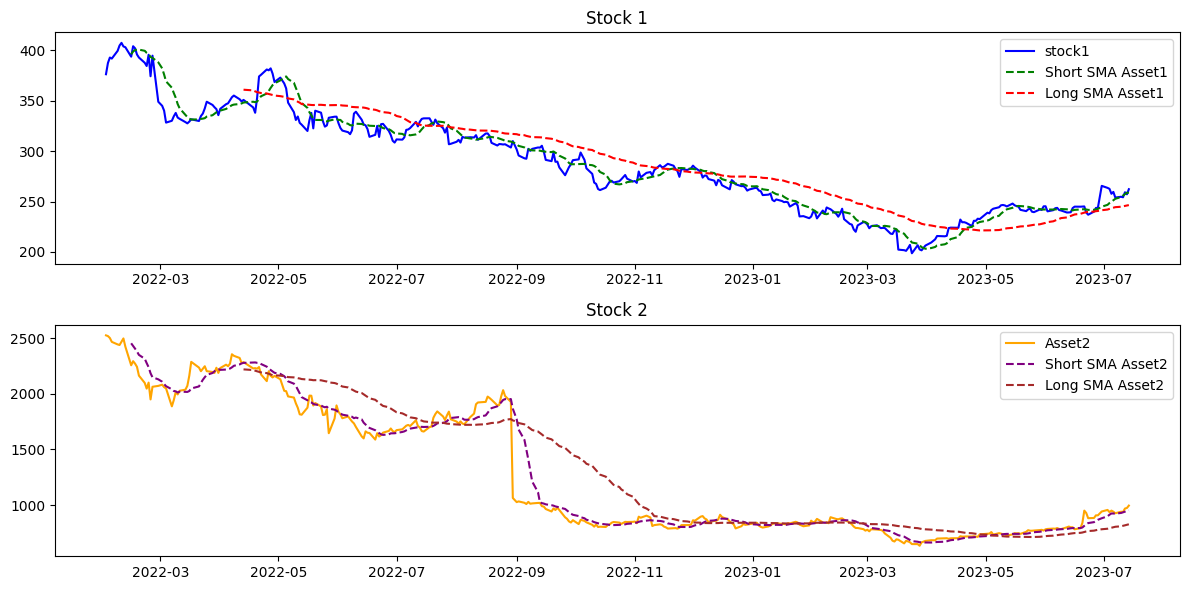

In [20]:
import matplotlib.pyplot as plt

# Assuming you have already generated 'signals_stock1' and 'signals_stock2' DataFrames.
# If 'Date' is not set as the index, you can set it using the following:
# stock1_data.set_index('Date', inplace=True)
# stock2_data.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))

# Plot stock1_data
plt.subplot(2, 1, 1)
plt.plot(stock1_data.index, stock1_data['Close'], label='stock1', color='blue')
plt.plot(stock1_data.index, signals_stock1['short_sma_asset1'], label='Short SMA Asset1', linestyle='--', color='green')
plt.plot(stock1_data.index, signals_stock1['long_sma_asset1'], label='Long SMA Asset1', linestyle='--', color='red')
plt.title('Stock 1')
plt.legend()

# Plot stock2_data
plt.subplot(2, 1, 2)
plt.plot(stock2_data.index, stock2_data['Close'], label='Asset2', color='orange')
plt.plot(stock2_data.index, signals_stock2['short_sma_asset2'], label='Short SMA Asset2', linestyle='--', color='purple')
plt.plot(stock2_data.index, signals_stock2['long_sma_asset2'], label='Long SMA Asset2', linestyle='--', color='brown')
plt.title('Stock 2')
plt.legend()

plt.tight_layout()
plt.show()


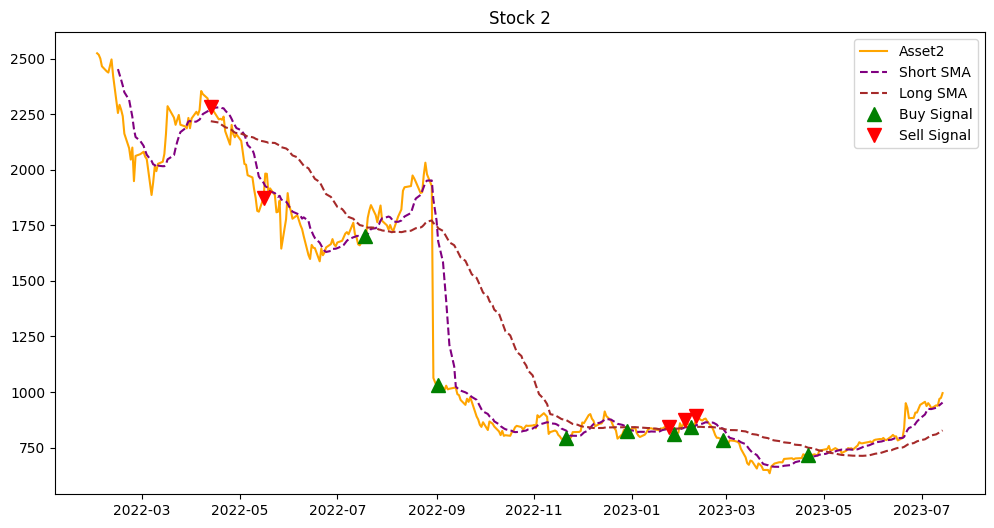

In [18]:
plt.plot(stock1_data.index, signals_stock1['short_sma_asset1'], label='Short SMA', linestyle='--', color='green')
plt.plot(stock1_data.index, signals_stock1['long_sma_asset1'], label='Long SMA', linestyle='--', color='red')
plt.plot(signals_stock1[signals_stock1['positions'] == 1.0].index, stock1_data['Close'][signals_stock1['positions'] == 1.0], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals_stock1[signals_stock1['positions'] == -1.0].index, stock1_data['Close'][signals_stock1['positions'] == -1.0], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Stock 1')
plt.legend()

# Plot the buy/sell signals on the stock2 chart
plt.figure(figsize=(12, 6))
plt.plot(stock2_data.index, stock2_data['Close'], label='Asset2', color='orange')
plt.plot(stock2_data.index, signals_stock2['short_sma_asset2'], label='Short SMA', linestyle='--', color='purple')
plt.plot(stock2_data.index, signals_stock2['long_sma_asset2'], label='Long SMA', linestyle='--', color='brown')
plt.plot(signals_stock2[signals_stock2['positions'] == 1.0].index, stock2_data['Close'][signals_stock2['positions'] == 1.0], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals_stock2[signals_stock2['positions'] == -1.0].index, stock2_data['Close'][signals_stock2['positions'] == -1.0], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Stock 2')
plt.legend()

plt.show()






